In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
df = pd.read_csv('binance_nostra_eth_usdc.csv')

In [19]:
df.to_csv('binance_nostra_eth_usdc.csv', index=False)

In [4]:
df.head()

,block_number,datetime_utc,price_nostra,price_binance,usdc_liquidity,eth_liquidity,mav
0,514800,2024-01-22 14:05:48+00:00,2385.496183,2387.08,2.5,0.001048,2.755069e-07
1,514801,2024-01-22 14:06:51+00:00,2385.496183,2383.72,2.5,0.001048,3.464959e-07
2,514802,2024-01-22 14:07:45+00:00,2385.496183,2383.54,2.5,0.001048,4.202828e-07
3,514803,2024-01-22 14:08:37+00:00,2385.496183,2385.10,2.5,0.001048,1.723910e-08
4,514804,2024-01-22 14:09:51+00:00,2385.496183,2384.90,2.5,0.001048,3.903750e-08


# Theory of Arbitrage and LVR

Price disparities across different trading platforms (both DEXs and CEXs) present arbitrage opportunities. In this section, we calculate the transaction volume required to align prices between AMM-DEX and CEX, given the existing token reserves in an AMM liquidity pool. Trading this volume maximizes the arbitrageur’s profit, which is called net LVR, or the Maximal Arbitrage Value (MAV). For simplicity, we further assume that trading on the CEX has no price impact due to the typically higher reserves compared to AMM-DEXs.

## Maximal Arbitrage Value

Consider a scenario in which there is a price discrepancy between a CEX and an AMM, the CEX having a substantially higher market depth, resulting in zero market impact. Let \(P_c\) and \(P_a\) be the prices at CEX and AMM, respectively, and assume that \(P_c < P_a\). Let \(V_{max}\) denote the maximum trade volume that was bought on the CEX for \(P_c\) and sold on the AMM for \(P_a\) equals the prices. With \(V_{max}\) being the trading volume that equals the prices at AMM and CEX and percentage price impact \(\rho(V_{max})\), MAV is defined as:

$$
MAV = V_{max} \cdot \left( P_a \cdot (1 - \rho(V_{max})) - P_c \right)
$$

or equivalently

$$
MAV = V_{max} \cdot (P_a - P_c) - V_{max} \cdot P_a \cdot \rho(V_{max}).
$$

## Arbitrage between a CPMM and CEX

Let us assume that we have two tokens \(X\) and \(Y\), the respective reserves in the liquidity pool of AMM are \(x_1 = x\) and \(x_2 = y\). Assuming that we are dealing with a CPMM, the act of trading follows the \(x_1 \cdot x_2 = x \cdot y = L\) formula, and the instantaneous exchange rate \(P_a\) for an infinitesimal trade is

$$
P_a = \frac{x}{y}.
$$

and the percentage price impact on a CPMM (such as Uniswap v2) is given by \(\Delta x / x\) for a swap of \(\Delta x\) for \(\Delta y\). The MAV can be expressed as:

$$
MAV = V_{max} \cdot (P_a - P_c) - \frac{V_{max}^2 P_a}{x},
$$

Following \[13, 16\] we can compute the first derivative of Eq. (3) with respect to \(V_{max}\) to find the max points, receiving:

$$
V_{max} = \frac{y \cdot (P_a - P_c)}{2P_a}.
$$

And, by substituting (4) into (3) the MAV is written as:

$$
MAV = \frac{y \cdot (P_a - P_c)^2}{4P_a}.
$$


In [12]:
def mav_cpmm(row):
    y = row['eth_liquidity']
    Pa = row['price_nostra']
    Pc = row['price_binance']
    if Pa == 0.0: return np.nan
    return (y * (Pa - Pc)**2) / (4 * Pa)

In [69]:
df['mav'] = df.apply(mav_cpmm, axis=1)

In [5]:
df.mav.describe()

count    1.219450e+05
mean     1.429993e+00
std      1.157480e+01
min      4.110983e-12
25%      6.610572e-02
50%      3.116398e-01
75%      1.003038e+00
max      2.485569e+03
Name: mav, dtype: float64

In [6]:
df[df.mav > 1000]

,block_number,datetime_utc,price_nostra,price_binance,usdc_liquidity,eth_liquidity,mav
81203,596003,2024-02-29 17:01:48+00:00,3918.691811,3445.8,682722.947915,174.222159,2485.569306


In [25]:
# Approximate MAV to 2 decimal places
df['mav'] = df['mav'].round(1)

In [33]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

In [46]:
P99 = df.mav.quantile(0.99)
Q3 = df.mav.quantile(0.75)
Q1 = df.mav.quantile(0.25)
IQR = Q3 - Q1

upper_outliers = df[df.mav > P99]

upper_outliers.head()

,block_number,datetime_utc,price_nostra,price_binance,usdc_liquidity,eth_liquidity,mav
5383,520183,2024-01-26 16:07:01+00:00,2204.598865,2268.74,77542.419374,35.173029,16.4
5384,520184,2024-01-26 16:07:55+00:00,2204.598865,2266.63,77542.419374,35.173029,15.4
5385,520185,2024-01-26 16:08:58+00:00,2204.598865,2267.64,77552.463873,35.177585,15.8
5388,520188,2024-01-26 16:13:52+00:00,2204.598865,2266.86,77552.463873,35.177585,15.5
5389,520189,2024-01-26 16:15:03+00:00,2204.598865,2266.74,77557.741929,35.179979,15.4


In [52]:
upper_outliers.describe()

,block_number,price_nostra,price_binance,usdc_liquidity,eth_liquidity,mav
count,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000
mean,567333.064039,3022.227330,3019.497200,449091.712839,145.654018,53.799507
std,26639.495974,409.147818,390.197755,150335.169129,43.280691,101.908354
min,520183.000000,2204.598864,2263.890000,77542.419374,35.173029,14.700000
25%,557323.250000,2884.147383,2926.680000,444406.393894,150.267338,18.100000
50%,558135.500000,2976.489038,2944.690000,454290.014153,153.053811,25.100000
75%,594726.750000,3311.542606,3259.297500,495352.737046,167.388526,49.800000
max,632434.000000,4048.187193,4003.940000,682722.947915,216.500072,2485.600000


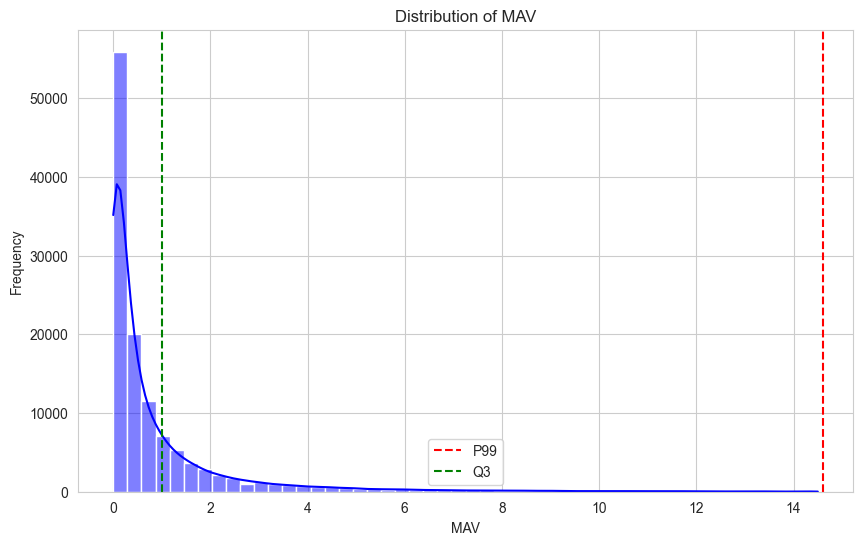

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df.mav < P99].mav, bins=50, kde=True, color='blue')
plt.title('Distribution of MAV')
plt.xlabel('MAV')
plt.ylabel('Frequency')
plt.axvline(P99, color='red', linestyle='--', label='P99')
plt.axvline(Q3, color='green', linestyle='--', label='Q3')
plt.legend()
plt.show()

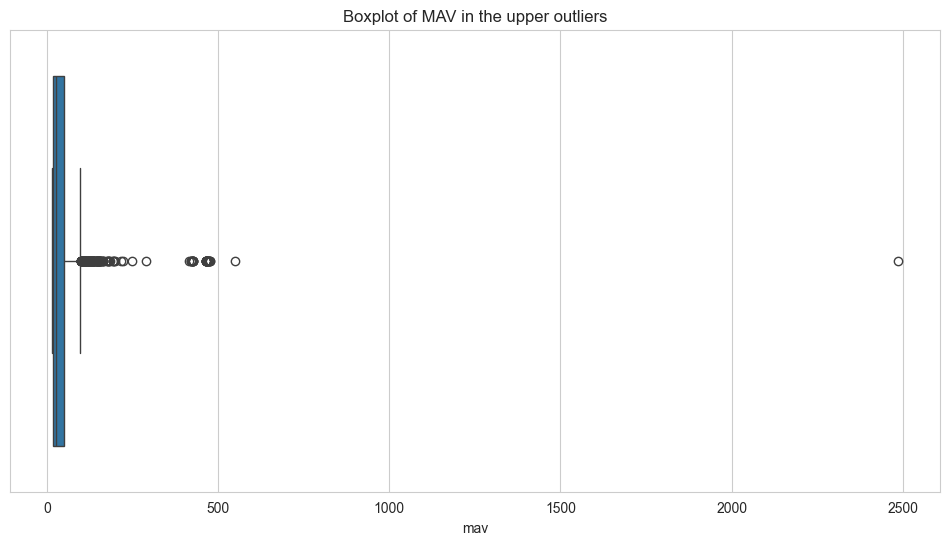

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='mav', data=upper_outliers)
plt.title('Boxplot of MAV in the upper outliers')
plt.show()

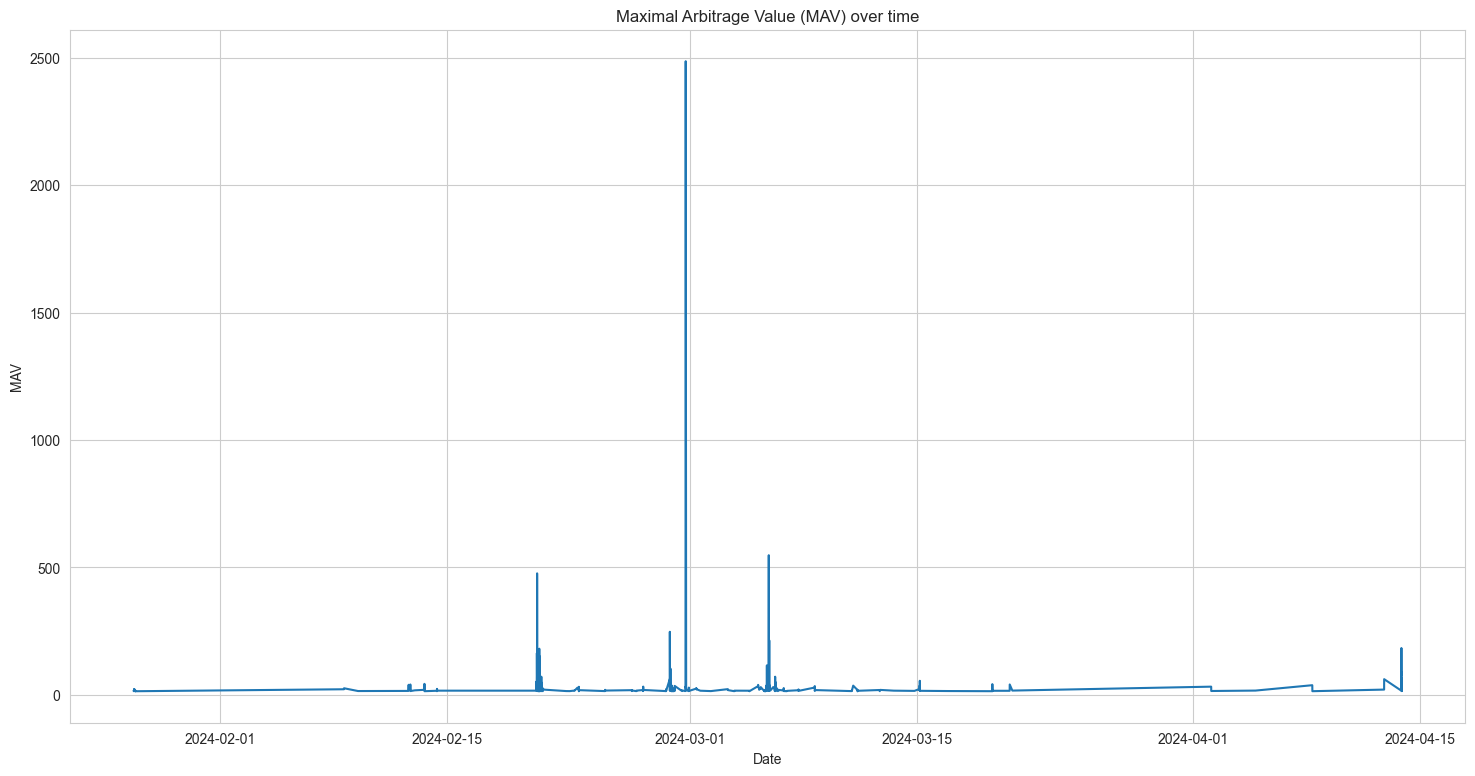

In [67]:
# Plotting the MAV, Maximal Arbitrage Value. Logarithmic scale
plt.figure(figsize=(18, 9))
plt.plot(upper_outliers['datetime_utc'], upper_outliers['mav'])
plt.title('Maximal Arbitrage Value (MAV) over time')
plt.ylabel('MAV')
plt.xlabel('Date')
plt.show()


In [50]:
# Identify the max MAV
max_mav = df[df.mav == df.mav.max()]

max_mav

,block_number,datetime_utc,price_nostra,price_binance,usdc_liquidity,eth_liquidity,mav
81203,596003,2024-02-29 17:01:48+00:00,3918.691811,3445.8,682722.947915,174.222159,2485.6


In [7]:
total_mav = df.mav.sum()

float(total_mav)


174380.45666355453

In [29]:
data = {
    "Chain": [
        "Arbitrum",
        "Arbitrum (USDC.e)",
        "Base",
        "Optimism (USDC.e)",
        "zkSync Era (USDC.e)",
        "Starknet (Nostra V2)"
    ],
    "MAV": [
        2699032.60,
        2707008.96,
        1293771.96,
        690868.44,
        20110.31,
        total_mav
    ]
}

df_mav = pd.DataFrame(data)
df_mav = df_mav.sort_values(by='MAV', ascending=False)
df_mav

,Chain,MAV
1,Arbitrum (USDC.e),2.707009e+06
0,Arbitrum,2.699033e+06
2,Base,1.293772e+06
3,Optimism (USDC.e),6.908684e+05
5,Starknet (Nostra V2),1.743805e+05
4,zkSync Era (USDC.e),2.011031e+04


In [46]:
fig = px.bar(
    df_mav, 
    y='Chain', 
    x='MAV', 
    title='Maximal Arbitrage Value by L2 Chain (ETH / USDC) from December 31, 2023 to April 30, 2024', 
    labels={'MAV': 'MAV', 'Chain': 'Chain'},
    color=df_mav['Chain'].apply(lambda x: 'Highlighted' if x == 'Starknet (Nostra V2)' else 'Normal')
)

fig.update_yaxes(categoryorder='total ascending')
fig.update_layout(showlegend=False)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{x:.2s}', textposition='outside')

fig.show()